## Initialization

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline
from scipy.spatial.distance import cosine

In [ ]:
df = pd.read_csv ('https://raw.githubusercontent.com/thatNitinVinayak/Inventory-Management-using-IoT/main/References/Reference%20Code/dataset/Items.csv')

In [ ]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04-07-2019 22.30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04-12-2019 14.38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04-12-2019 14.38,"669 Spruce St, Los Angeles, CA 90001"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/OnlineRetail.xlsx'
dataset = pd.read_excel(path)

In [ ]:
print('Dataset Dimensions : ', dataset.shape)
dataset.describe(include = 'all')

Dataset Dimensions :  (541909, 8)


<ipython-input-7-94a0e184a5b8>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset.describe(include = 'all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [ ]:
dataset_sample = dataset.iloc[:4000]

## Data Preprocessing

In [ ]:
# Delete Rows with no Customer ID (if there is such a case)
cleaned_retail = dataset_sample.loc[pd.isnull(dataset_sample.CustomerID) == False]

# Create a Lookup Table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

# Data Cleaning to Raw Data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
print()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')

<ipython-input-9-6d2fc95d9cd0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# Count Number of Products and Number of Customers in the Reduced Dataset 
products_num = len(grouped_purchased.StockCode.unique())
customers_num = len(grouped_purchased.CustomerID.unique())
print('Number of Customers in Dataset:', customers_num)
print('Number of Products in Dataset:', products_num)

Number of Customers in Dataset: 137
Number of Products in Dataset: 1131


## Creation of Bipartite Graph

In [ ]:
# Turn Raw Data to Pivot ('ratings' Matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns = 'StockCode', values = 'Quantity').fillna(0).astype('int')
# Binarize the Ratings Matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1

## Conversion to a Weighted Product Graph

In [21]:
# Initialize Zeros Dataframe for Product Interactions
products_integer = np.zeros((products_num, products_num))

# Count how many times each Product Pair has been Purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(products_num):
    for j in range(products_num):
        if i != j:
            df_ij = ratings_binary.iloc[:,[i,j]] # Create a Temporary Dataset 'df' with only i and j Products as Columns
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2]) # if s1_ij == 2 it means that both Products were Purchased by the Same Customer
            products_integer[i,j] = pairings_ij
            products_integer[j,i] = pairings_ij

Counting how many times each pair of products has been purchased...


In [22]:
# Count how many Customers have Purchased each Item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)

Counting how many times each individual product has been purchased...


In [23]:
print (times_purchased)

[30. 73. 27. ... 20. 63. 34.]


## Building Product Matrix

In [25]:
# Construct Final Weighted Matrix of Item Interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((products_num, products_num))
for i in range(products_num):
    for j in range(products_num):
        if (times_purchased[i] + times_purchased[j]) != 0: # Make sure you do not Divide with Zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])

Building weighted product matrix...


## Visualization of Weighted Product Matrix

In [27]:
# Get List of Item Labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index = item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

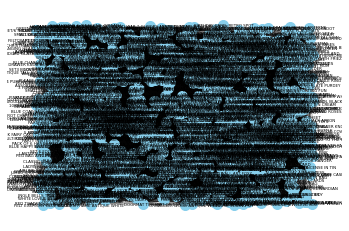

In [30]:
# Create Graph Object using the Weighted Product Matrix as Adjacency Matrix
G = nx.from_numpy_array(products_weighted)
pos = nx.random_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

nx.draw_networkx_nodes(G, pos, node_color = "skyblue", node_size = 100)
nx.draw_networkx_edges(G, pos,  edge_color = 'k', width = 0.3, alpha = 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size = 4)
plt.axis('off')
plt.show()

## Exporting the Graph to Gephi

In [33]:
H = nx.relabel_nodes(G, labels) # Create a New Graph with Description Labels and Save to Gephi for better Visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

In [34]:
# Function for Setting Colors of Nodes and Edges
def get_paired_color_palette(size):
    palette = []
    for i in range(size * 2):
        palette.append(plt.cm.Paired(i))
    return palette

# Find Communities of Nodes (products)
louvain = community_louvain.best_partition(G, resolution = 1.5)
values = list(louvain.values())

communities = []

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n] == i)]
    communities.append(nodelist)

## Visualize Detected Communities

In [35]:
# Make Plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize = (10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

# Iterate through each of the Communities found by the Louvain Algorithm and Plot
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n] == i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]] == i) or (louvain[e[1]] == i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist = nodelist, node_color = node_color, edgecolors = 'k', label = i)                                                                                                           
    nx.draw_networkx_edges(G, g, edgelist = edgelist, alpha = .5, edge_color = edge_color)

# Set Title, Legend and ShowPplot
plt.title('Communities in Commodity Purchase Trend', fontdict = {'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

AttributeError: ignored

<Figure size 720x720 with 0 Axes>